In [26]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np

## Encoder architecture
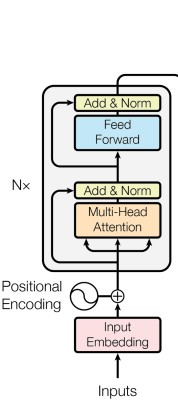

## Transformers 
`encoder decoder model which can take in a sequence of input at once and process each token parallely , hence eleminating the need for a sequential computation as in RNN and LSTM`

***how does it do that ?***
- 2 major features of a transformer which allow it to have this capability are:
1. self attention 
2. positional embedding 

***self attention*** : the problem that attention mechanism addresses is *The Problem of Fixed Encoder Representation* , In all the encoder decoder architectures before transformers , the encoder would basically spit out a latent representation of all input tokens and the decoder would then output based on the aggregated representation of every token. The problem is when the encoder is forced to put all the information through various timestamps into one representation it is likely to forget something.<br>
self attention in contrast addresses this issue of fading information by taking in all tokens at once such that tokens interact with each other. Each token looks at other tokens in the sequence , according to a *attention score* and updates its own representation taking into context the importance of other tokens. 


Query, Key, and Value in Self-Attention:
- query - looking at other tokens in the sequence.
- key - responding to query request by jelping in attention score calculation .
- value - gives information to the token as to how much other tokens are actully important.

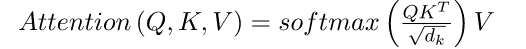

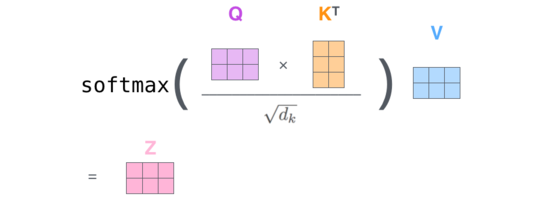
<br>
PS: dot product between Q and K is one of the ways to calculate attention score , many other ways also exist.<br>

Self attention can also be thought of as weighted sum , where the weights calculated are the attetnion scores.

In [12]:
def self_attention(keys , queries , values , head_dim , heads , batch_size):
    # scale queries and keys 
    queries = queries / (head_dim ** (1/2))
    keys    = keys / (head_dim ** (1/2))

    # multiply queries and keys 
    dot = torch.bmm(queries, keys.transpose(1, 2))
    dot = F.softmax(dot, dim=2) 
    # split into heads again 
    _ , value_token_len , _ = values.shape
    print(dot.shape , values.shape )
    out = torch.bmm(dot, values).view(batch_size, heads, value_token_len, head_dim)
    return out 
    

In [13]:
# input >>>> keys , queries , values , :
# output = (keys*query.T / scaler )V

class MultiHeadAttention(nn.Module):
    def __init__(self , heads , input_embed_size):
        super(MultiHeadAttention, self).__init__()
        self.heads = heads
        self.head_dim = input_embed_size//self.heads
        self.embed_size = input_embed_size 
        self.queries = nn.Linear(self.head_dim , self.head_dim)
        self.keys = nn.Linear(self.head_dim , self.head_dim)
        self.values = nn.Linear(self.head_dim , self.head_dim)
        
        self.fc_attn = nn.Linear(heads*self.head_dim , self.embed_size) # same as input
    def forward(self , batch_size , keys , queries , values):
        # split the keys , queri , values into the number of heads 
        # batch_size, token_size , heads ,  embed_size 
        key_token_len , value_token_len , query_token_len = keys.shape[1] , values.shape[1] , queries.shape[1]
        keys = keys.reshape(batch_size  , key_token_len , self.heads , self.head_dim)
        values = values.reshape(batch_size  , value_token_len , self.heads , self.head_dim)
        queries = queries.reshape(batch_size  , query_token_len , self.heads , self.head_dim)
        
        # fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(batch_size * self.heads, key_token_len, self.head_dim)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * self.heads, query_token_len, self.head_dim)
        values = values.transpose(1, 2).contiguous().view(batch_size * self.heads, value_token_len, self.head_dim)
        
        out = self_attention(keys , queries , values , self.head_dim , self.heads , batch_size)
        # to concatenate we need the heads dim and embedding dimention nect to each other 
        out = out.transpose(1, 2).contiguous().view(batch_size, value_token_len, self.heads * self.head_dim)
        
        # linear layer 
        out = self.fc_attn(out)
        
        return out 


In [14]:
class FeedForward(nn.Module):
    def __init__(self , embed_size , linear_out_size):
        super(FeedForward , self).__init__()
        self.linear1 = nn.Linear(embed_size , linear_out_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(linear_out_size , embed_size)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self , x):
        out = self.dropout(self.linear2(self.relu(self.linear1(x))))
        return out

In [15]:
import numpy as np 
def positional_encodings(embed_dim_size , sequence_len):
    all_pos = np.empty((sequence_len , embed_dim_size))
    for pos in range(sequence_len):
        for i in range(embed_dim_size):
            if i%2==0:
                np.append(all_pos , np.sin(pos/np.power(10000 , 2*i/embed_dim_size)))
            else:
                np.append(all_pos , np.cos(pos/np.power(10000 , (2*i+1)/embed_dim_size)))
    all_pos = torch.as_tensor(all_pos, dtype=torch.long)
    print("type of positional encoding " , all_pos.dtype)
    return all_pos

# positional_encodings(32 , 5)

In [21]:
class Encoder(nn.Module):
    # attention + norm + fnn + norm 
    def __init__(self , input_embed_size , heads , linear_out_size):
        super(Encoder , self).__init__()
        self.norm1 = nn.LayerNorm(input_embed_size)
        self.norm2 = nn.LayerNorm(input_embed_size)
        self.ffn = FeedForward(input_embed_size , linear_out_size)
        self.attention = MultiHeadAttention(heads , input_embed_size)
        
    def forward(self , values , keys , queries):
        attention = self.attention(1, values, keys, queries)
        print("attention outputs " , attention)
        # Add skip connection, run through normalization and finally dropout
        x = self.norm1(attention + queries)
        forward = self.ffn(x)
        out = self.norm2(forward + x)
        return out

In [22]:
class Transformer(nn.Module):
    def __init__(self , vocab_size , embed_size ,max_seq_len , linear_expansion , dropout , heads , linear_exapansion , num_layers):
        super(Transformer , self).__init__()
        self.embed_size = embed_size
        self.max_seq_len = max_seq_len
        self.word_embed = nn.Embedding(vocab_size ,embed_size )
        self.layers = nn.ModuleList(
        [
            Encoder(
                embed_size , heads , linear_exapansion
            )
            for _ in range(num_layers)
        ]
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self , x):
        N, seq_length = x.shape
        #positional_encodings(self.embed_size ,self.max_seq_len)
        out = self.dropout(
            (self.word_embed(x) + positional_encodings(self.embed_size ,self.max_seq_len))
        )
        
        
        # In the Encoder the query, key, value are all the same.
        for layer in self.layers:
            out = layer(out, out, out)

        return out

In [23]:
obj_transformer = Transformer(10 , 10 , 1 , 5 , 0.1 , 2 , 128 , 2)

In [24]:
import torch
x = torch.tensor([0.2 , 2.0, 3.6 , 2 , 1, 1, 1, 1 , 1 , 3 ] , dtype=torch.long).unsqueeze(0)

<ipython-input-24-1a9fb8712ce7>:2: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  x = torch.tensor([0.2 , 2.0, 3.6 , 2 , 1, 1, 1, 1 , 1 , 3 ] , dtype=torch.long).unsqueeze(0)
